<a href="https://colab.research.google.com/github/imdeepmind/CrowdCounter/blob/master/Crowd_Counter_(InceptionResnetV2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Getting the dataset into proper place
!mkdir data
!cp '/content/drive/My Drive/datasets/dataset.zip' ./
!unzip -qq dataset.zip -d ./data/
!rm dataset.zip

In [2]:
# Script to generate the processed.csv file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

labels = pd.read_csv('data/labels.csv')

preprocessed_labels = []
preprocessed_images = []

images = os.listdir("/content/data/frames/frames")

for (id, count) in labels.values:
  preprocessed_labels.append(count)
  preprocessed_images.append(images[id-1])

df = pd.DataFrame(columns=['image', 'count'])
df['image'] = preprocessed_images
df['count'] = preprocessed_labels

df.head()

df.to_csv('./data/processed.csv', index=False)

In [3]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import MeanSquaredError, Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import InceptionResNetV2

In [4]:
# Reading data
data = pd.read_csv("./data/processed.csv")

data.head()

,image,count
0,seq_001953.jpg,35
1,seq_000090.jpg,41
2,seq_001454.jpg,41
3,seq_000033.jpg,44
4,seq_000534.jpg,41


In [5]:
train, test = train_test_split(data, test_size=0.1, random_state=1969)

train.head()

,image,count
261,seq_001599.jpg,18
962,seq_000833.jpg,31
592,seq_001483.jpg,25
884,seq_000197.jpg,25
84,seq_001613.jpg,31


In [6]:
train_generator = ImageDataGenerator(rotation_range=180, horizontal_flip=True, vertical_flip=True, rescale=1/255.)
test_generator = ImageDataGenerator(rescale=1/255.)

In [7]:
train_data = train_generator.flow_from_dataframe(train, 
                                                 directory='./data/frames/frames/', 
                                                 x_col='image', 
                                                 y_col='count', 
                                                 target_size=(640, 480),
                                                 color_mode='rgb',
                                                 class_mode='raw',
                                                 batch_size=16,
                                                 shuffle=True)

test_data = test_generator.flow_from_dataframe(test, 
                                                 directory='./data/frames/frames/', 
                                                 x_col='image', 
                                                 y_col='count', 
                                                 target_size=(640, 480),
                                                 color_mode='rgb',
                                                 class_mode='raw',
                                                 batch_size=16,
                                                 shuffle=True)


Found 1800 validated image filenames.
Found 200 validated image filenames.


In [12]:
model = Sequential()

pretrainedModels = InceptionResNetV2(include_top=False,
                                     weights="imagenet", 
                                     input_shape=(640,480,3),
                                     pooling="avg")
model = Sequential()

model.add(pretrainedModels)
model.add(Dense(1))

In [13]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 1536)              54336736  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1537      
Total params: 54,338,273
Trainable params: 54,277,729
Non-trainable params: 60,544
_________________________________________________________________


In [15]:
earlyStopper = EarlyStopping(patience=3, restore_best_weights=True)

In [16]:
history = model.fit(train_data, 
          steps_per_epoch=1800//16,
          validation_data=test_data,
          validation_steps=200//16,
          epochs=100,
          callbacks=[earlyStopper])

Epoch 1/100
112/112 [==============================] - 177s 2s/step - loss: 136.3566 - mae: 8.7602 - val_loss: 80.4020 - val_mae: 7.1151
Epoch 2/100
112/112 [==============================] - 172s 2s/step - loss: 49.9170 - mae: 5.6307 - val_loss: 200.1891 - val_mae: 8.0073
Epoch 3/100
112/112 [==============================] - 172s 2s/step - loss: 49.4899 - mae: 5.6102 - val_loss: 67.2501 - val_mae: 6.4062
Epoch 4/100
112/112 [==============================] - 171s 2s/step - loss: 53.5209 - mae: 5.7480 - val_loss: 103.4653 - val_mae: 8.0692
Epoch 5/100
112/112 [==============================] - 171s 2s/step - loss: 50.1675 - mae: 5.6509 - val_loss: 86.9294 - val_mae: 8.0185
Epoch 6/100
112/112 [==============================] - 171s 2s/step - loss: 49.6040 - mae: 5.6256 - val_loss: 47.3859 - val_mae: 5.2739
Epoch 7/100
112/112 [==============================] - 170s 2s/step - loss: 49.1995 - mae: 5.5989 - val_loss: 48.4284 - val_mae: 5.6566
Epoch 8/100
112/112 [========================

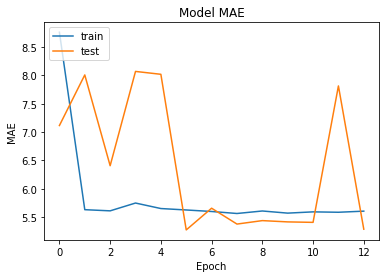

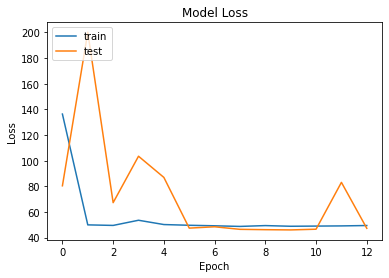

In [17]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
model.save("best.h5")